In [2]:
pip install git+https://github.com/google-research/timesfm


  Cloning https://github.com/google-research/timesfm to /tmp/pip-req-build-l87i5ey0
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/timesfm /tmp/pip-req-build-l87i5ey0
  Resolved https://github.com/google-research/timesfm to commit 4b974eae481e07ca3ffd2ded2089a56b48181fce
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [1]:
!pip install yfinance
!pip install utilsforecast


In [3]:
# Importing relevant packages for finetuning
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['JAX_PMAP_USE_TENSORSTORE'] = 'false'
import timesfm
import gc
import numpy as np
import pandas as pd
from timesfm import patched_decoder
from timesfm import data_loader
from tqdm import tqdm
import dataclasses
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
# Loading TimesFM pretrained checkpoint
tfm = timesfm.TimesFm(
    context_len=512,
    horizon_len=1,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend="gpu",
)
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/5.73k [00:00<?, ?B/s]

(…)nts/checkpoint_1100000/metadata/metadata:   0%|          | 0.00/43.9k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

(…)oint_1100000/descriptor/descriptor.pbtxt:   0%|          | 0.00/499 [00:00<?, ?B/s]

checkpoint:   0%|          | 0.00/814M [00:00<?, ?B/s]

Constructing model weights.


Constructed model weights in 9.05 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 2.60 seconds.
Jitting decoding.
Jitted decoding in 27.67 seconds.


[*********************100%%**********************]  1 of 1 completed


In [4]:
import jax
from jax import numpy as jnp
from praxis import pax_fiddle
from praxis import py_utils
from praxis import pytypes
from praxis import base_model
from praxis import optimizers
from praxis import schedules
from praxis import base_hyperparams
from praxis import base_layer
from paxml import tasks_lib
from paxml import trainer_lib
from paxml import checkpoints
from paxml import learners
from paxml import partitioning
from paxml import checkpoint_types
import yfinance as yf

In [ ]:
ticker = 'AAPL'
data = yf.download(ticker, start="2013-01-01", end="2023-01-01")
data.rename(columns={'Date': 'date', 'Close': 'y'}, inplace=True)
data['unique_id'] = 'AAPL'  # Add a unique_id column
data.reset_index(inplace=True)

data_path = 'stock_data.csv'
data.to_csv(data_path, index=False)

In [ ]:
freq = 'D'
context_len = 512
pred_len = 1
batch_size = 16

# Define train, validation, and test boundaries
train_boundary = int(len(data) * 0.7)
val_boundary = int(len(data) * 0.85)

In [ ]:
train_boundary

1762

In [ ]:
# Create TimeSeriesdata loader
dtl = data_loader.TimeSeriesdata(
      data_path=data_path,
      datetime_col="Date",
      num_cov_cols=None,
      cat_cov_cols=None,
      ts_cols=np.array(['y']),
      train_range=[0, train_boundary],
      val_range=[train_boundary, val_boundary],
      test_range=[val_boundary, len(data)],
      hist_len=context_len,
      pred_len=pred_len,
      batch_size=1,  # Change as per requirement
      freq=freq,
      normalize=True,
      epoch_len=None,
      holiday=False,
      permute=True,
  )
train_batches = dtl.tf_dataset(mode="train", shift=1).batch(batch_size)
val_batches = dtl.tf_dataset(mode="val", shift=pred_len)
test_batches = dtl.tf_dataset(mode="test", shift=pred_len)

# Fine-tuning the model

In [ ]:


batch_size=1
# PAX shortcuts
NestedMap = py_utils.NestedMap
WeightInit = base_layer.WeightInit
WeightHParams = base_layer.WeightHParams
InstantiableParams = py_utils.InstantiableParams
JTensor = pytypes.JTensor
NpTensor = pytypes.NpTensor
WeightedScalars = pytypes.WeightedScalars
instantiate = base_hyperparams.instantiate
LayerTpl = pax_fiddle.Config[base_layer.BaseLayer]
AuxLossStruct = base_layer.AuxLossStruct

AUX_LOSS = base_layer.AUX_LOSS
template_field = base_layer.template_field

# Standard prng key names
PARAMS = base_layer.PARAMS
RANDOM = base_layer.RANDOM

key = jax.random.PRNGKey(seed=1234)
model = pax_fiddle.Config(
    patched_decoder.PatchedDecoderFinetuneModel,
    name='patched_decoder_finetune',
    core_layer_tpl=tfm.model_p,
)

@pax_fiddle.auto_config
def build_learner() -> learners.Learner:
  return pax_fiddle.Config(
      learners.Learner,
      name='learner',
      loss_name='avg_qloss',
      optimizer=optimizers.Adam(
          epsilon=1e-7,
          clip_threshold=1e2,
          learning_rate=1e-2,
          lr_schedule=pax_fiddle.Config(
              schedules.Cosine,
              initial_value=1e-3,
              final_value=1e-4,
              total_steps=40000,
          ),
          ema_decay=0.9999,
      ),
      bprop_variable_exclusion=['.*/stacked_transformer_layer/.*'],
  )

task_p = tasks_lib.SingleTask(
    name='ts-learn',
    model=model,
    train=tasks_lib.SingleTask.Train(
        learner=build_learner(),
    ),
)
task_p.model.ici_mesh_shape = [1, 1, 1]
task_p.model.mesh_axis_names = ['replica', 'data', 'mdl']

DEVICES = np.array(jax.devices()).reshape([1, 1, 1])
MESH = jax.sharding.Mesh(DEVICES, ['replica', 'data', 'mdl'])

num_devices = jax.local_device_count()
print(f'num_devices: {num_devices}')
print(f'device kind: {jax.local_devices()[0].device_kind}')
jax_task = task_p
key, init_key = jax.random.split(key)

def process_train_batch(batch):
    past_ts = batch[0].reshape(batch_size, -1)
    actual_ts = batch[3].reshape(batch_size, -1)
    return NestedMap(input_ts=past_ts, actual_ts=actual_ts)

def process_eval_batch(batch):
    past_ts = batch[0]
    actual_ts = batch[3]
    return NestedMap(input_ts=past_ts, actual_ts=actual_ts)

jax_model_states, _ = trainer_lib.initialize_model_state(
    jax_task,
    init_key,
    process_train_batch(tbatch),
    checkpoint_type=checkpoint_types.CheckpointType.GDA,
)

# Setting the initial model weights to the pretrained TimesFM parameters.
jax_model_states.mdl_vars['params']['core_layer'] = tfm._train_state.mdl_vars['params']
jax_vars = jax_model_states.mdl_vars
gc.collect()

# Training loop
jax_task = task_p

def train_step(states, prng_key, inputs):
  return trainer_lib.train_step_single_learner(
      jax_task, states, prng_key, inputs
  )

def eval_step(states, prng_key, inputs):
  states = states.to_eval_state()
  return trainer_lib.eval_step_single_learner(
      jax_task, states, prng_key, inputs
  )

key, train_key, eval_key = jax.random.split(key, 3)
train_prng_seed = jax.random.split(train_key, num=jax.local_device_count())
eval_prng_seed = jax.random.split(eval_key, num=jax.local_device_count())

p_train_step = jax.pmap(train_step, axis_name='batch')
p_eval_step = jax.pmap(eval_step, axis_name='batch')
replicated_jax_states = trainer_lib.replicate_model_state(jax_model_states)
replicated_jax_vars = replicated_jax_states.mdl_vars
best_eval_loss = 1e7
step_count = 0
patience = 0
NUM_EPOCHS = 100
PATIENCE = 5
TRAIN_STEPS_PER_EVAL = 1000
CHECKPOINT_DIR='/content'  # Change to your path

def reshape_batch_for_pmap(batch, num_devices):
  def _reshape(input_tensor):
    bsize = input_tensor.shape[0]
    residual_shape = list(input_tensor.shape[1:])
    nbsize = bsize // num_devices
    return jnp.reshape(input_tensor, [num_devices, nbsize] + residual_shape)

  return jax.tree.map(_reshape, batch)

for epoch in range(NUM_EPOCHS):
    print(f"__________________Epoch: {epoch}__________________", flush=True)
    train_its = train_batches.as_numpy_iterator()
    if patience >= PATIENCE:
        print("Early stopping.", flush=True)
        break
    for batch in tqdm(train_its):
        train_losses = []
        if patience >= PATIENCE:
            print("Early stopping.", flush=True)
            break
        tbatch = process_train_batch(batch)
        tbatch = reshape_batch_for_pmap(tbatch, num_devices)
        replicated_jax_states, step_fun_out = p_train_step(
            replicated_jax_states, train_prng_seed, tbatch
        )
        train_losses.append(step_fun_out.loss[0])
        if step_count % TRAIN_STEPS_PER_EVAL == 0:
            print(
                f"Train loss at step {step_count}: {np.mean(train_losses)}",
                flush=True,
            )
            train_losses = []
            print("Starting eval.", flush=True)
            val_its = val_batches.as_numpy_iterator()
            eval_losses = []
            for ev_batch in tqdm(val_its):
                ebatch = process_eval_batch(ev_batch)
                ebatch = reshape_batch_for_pmap(ebatch, num_devices)
                _, step_fun_out = p_eval_step(
                    replicated_jax_states, eval_prng_seed, ebatch
                )
                eval_losses.append(step_fun_out.loss[0])
            mean_loss = np.mean(eval_losses)
            print(f"Eval loss at step {step_count}: {mean_loss}", flush=True)
            if mean_loss < best_eval_loss or np.isnan(mean_loss):
                best_eval_loss = mean_loss
                print("Saving checkpoint.")
                jax_state_for_saving = py_utils.maybe_unreplicate_for_fully_replicated(
                    replicated_jax_states
                )
                checkpoints.save_checkpoint(
                    jax_state_for_saving, CHECKPOINT_DIR, overwrite=True
                )
                patience = 0
                del jax_state_for_saving
                gc.collect()
            else:
                patience += 1
                print(f"patience: {patience}")
        step_count += 1

# Loading and evaluating the best (according to validation loss) finetuned checkpoint
train_state = checkpoints.restore_checkpoint(jax_model_states, CHECKPOINT_DIR)
print(train_state.step)
tfm._train_state.mdl_vars['params'] = train_state.mdl_vars['params']['core_layer']
tfm.jit_decode()

mae_losses = []
for batch in tqdm(test_batches.as_numpy_iterator()):
    past = batch[0]
    actuals = batch[3]
    _, forecasts = tfm.forecast(list(past), [0] * past.shape[0])
    forecasts = forecasts[:, 0 : actuals.shape[1], 0]
    mae_losses.append(np.abs(forecasts - actuals).mean())

print(f"MAE: {np.mean(mae_losses)}")


num_devices: 1
device kind: Tesla T4
__________________Epoch: 0__________________


0it [00:00, ?it/s]

Train loss at step 0: 13.046916961669922
Starting eval.



0it [00:00, ?it/s]
1it [00:22, 22.24s/it]
9it [00:22,  1.80s/it]
17it [00:22,  1.27it/s]
27it [00:22,  2.53it/s]
37it [00:22,  4.26it/s]
47it [00:22,  6.62it/s]
57it [00:22,  9.79it/s]
67it [00:22, 13.88it/s]
76it [00:23, 18.41it/s]
85it [00:23, 23.85it/s]
96it [00:23, 32.37it/s]
106it [00:23, 40.55it/s]
116it [00:23, 48.96it/s]
126it [00:23, 57.18it/s]
136it [00:23, 64.76it/s]
146it [00:23, 71.42it/s]
156it [00:23, 76.95it/s]
166it [00:24, 80.54it/s]
176it [00:24, 83.86it/s]
186it [00:24, 86.49it/s]
196it [00:24, 88.43it/s]
206it [00:24, 89.75it/s]
216it [00:24, 90.73it/s]
226it [00:24, 91.47it/s]
236it [00:24, 92.10it/s]
246it [00:24, 92.42it/s]
256it [00:25, 92.28it/s]
266it [00:25, 92.31it/s]
276it [00:25, 92.31it/s]
286it [00:25, 92.52it/s]
296it [00:25, 92.74it/s]
306it [00:25, 92.87it/s]
316it [00:25, 93.06it/s]
326it [00:25, 93.14it/s]
336it [00:25, 93.33it/s]
346it [00:26, 93.28it/s]
356it [00:26, 93.08it/s]
366it [00:26, 93.06it/s]
378it [00:26, 14.34it/s]


Eval loss at step 0: 1.2177103757858276


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


157it [01:53,  1.39it/s]

__________________Epoch: 1__________________



157it [00:14, 10.93it/s]

__________________Epoch: 2__________________



157it [00:14, 10.83it/s]

__________________Epoch: 3__________________



157it [00:15, 10.39it/s]

__________________Epoch: 4__________________



157it [00:15,  9.96it/s]

__________________Epoch: 5__________________



157it [00:16,  9.68it/s]

__________________Epoch: 6__________________



58it [00:06,  9.93it/s]

Train loss at step 1000: 3.9600555896759033
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 91.87it/s]
20it [00:00, 88.80it/s]
29it [00:00, 88.32it/s]
38it [00:00, 87.81it/s]
47it [00:00, 87.42it/s]
56it [00:00, 87.49it/s]
65it [00:00, 86.92it/s]
74it [00:00, 87.10it/s]
83it [00:00, 85.68it/s]
92it [00:01, 85.17it/s]
101it [00:01, 85.50it/s]
110it [00:01, 85.79it/s]
119it [00:01, 86.25it/s]
128it [00:01, 86.53it/s]
137it [00:01, 86.78it/s]
146it [00:01, 86.86it/s]
155it [00:01, 86.92it/s]
164it [00:01, 86.41it/s]
173it [00:01, 85.85it/s]
182it [00:02, 85.96it/s]
191it [00:02, 86.26it/s]
200it [00:02, 85.38it/s]
210it [00:02, 87.17it/s]
219it [00:02, 87.18it/s]
228it [00:02, 87.04it/s]
237it [00:02, 87.19it/s]
246it [00:02, 86.81it/s]
255it [00:02, 86.44it/s]
264it [00:03, 86.15it/s]
273it [00:03, 86.06it/s]
282it [00:03, 86.38it/s]
291it [00:03, 86.66it/s]
300it [00:03, 86.76it/s]
309it [00:03, 86.87it/s]
318it [00:03, 86.97it/s]
327it [00:03, 86.95it/s]
336it [00:03, 86.55it/s]
345it [00:03, 86.29it/s]
354it [00:04, 86.11it/s]
363it [00:04, 8

Eval loss at step 1000: 14.464835166931152


61it [00:11,  1.42it/s]

patience: 1


157it [00:21,  7.47it/s]

__________________Epoch: 7__________________



157it [00:15,  9.98it/s]

__________________Epoch: 8__________________



157it [00:15, 10.08it/s]

__________________Epoch: 9__________________



157it [00:15, 10.13it/s]

__________________Epoch: 10__________________



157it [00:16,  9.81it/s]

__________________Epoch: 11__________________



157it [00:15, 10.03it/s]

__________________Epoch: 12__________________



116it [00:11,  9.96it/s]

Train loss at step 2000: 3.5910592079162598
Starting eval.



0it [00:00, ?it/s]
9it [00:00, 88.16it/s]
18it [00:00, 89.08it/s]
27it [00:00, 88.67it/s]
36it [00:00, 88.59it/s]
45it [00:00, 88.48it/s]
54it [00:00, 88.46it/s]
63it [00:00, 88.47it/s]
72it [00:00, 88.34it/s]
81it [00:00, 86.56it/s]
90it [00:01, 85.14it/s]
99it [00:01, 86.00it/s]
108it [00:01, 86.60it/s]
117it [00:01, 86.69it/s]
126it [00:01, 87.07it/s]
135it [00:01, 87.36it/s]
144it [00:01, 87.60it/s]
153it [00:01, 87.67it/s]
162it [00:01, 87.44it/s]
171it [00:01, 86.68it/s]
180it [00:02, 86.45it/s]
189it [00:02, 86.52it/s]
198it [00:02, 86.89it/s]
207it [00:02, 87.33it/s]
216it [00:02, 87.42it/s]
225it [00:02, 87.39it/s]
234it [00:02, 87.58it/s]
243it [00:02, 87.25it/s]
252it [00:02, 86.81it/s]
261it [00:02, 86.44it/s]
270it [00:03, 86.60it/s]
279it [00:03, 87.11it/s]
288it [00:03, 87.00it/s]
297it [00:03, 87.36it/s]
306it [00:03, 87.24it/s]
315it [00:03, 87.26it/s]
324it [00:03, 87.62it/s]
333it [00:03, 87.36it/s]
342it [00:03, 87.09it/s]
351it [00:04, 86.83it/s]
360it [00:04, 86.

Eval loss at step 2000: 16.254669189453125



118it [00:16,  1.30it/s]

patience: 2


157it [00:20,  7.67it/s]

__________________Epoch: 13__________________



157it [00:15,  9.86it/s]

__________________Epoch: 14__________________



157it [00:15,  9.93it/s]

__________________Epoch: 15__________________



157it [00:15, 10.01it/s]


__________________Epoch: 16__________________


157it [00:15, 10.10it/s]

__________________Epoch: 17__________________



157it [00:15,  9.98it/s]

__________________Epoch: 18__________________



157it [00:15,  9.89it/s]

__________________Epoch: 19__________________



16it [00:01,  9.80it/s]

Train loss at step 3000: 3.877246618270874
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 95.90it/s]
20it [00:00, 90.90it/s]
30it [00:00, 89.35it/s]
39it [00:00, 88.76it/s]
48it [00:00, 88.32it/s]
57it [00:00, 87.90it/s]
66it [00:00, 87.76it/s]
75it [00:00, 87.49it/s]
84it [00:00, 86.38it/s]
93it [00:01, 86.31it/s]
102it [00:01, 86.68it/s]
111it [00:01, 87.09it/s]
120it [00:01, 87.31it/s]
129it [00:01, 87.42it/s]
138it [00:01, 87.47it/s]
147it [00:01, 87.27it/s]
156it [00:01, 87.37it/s]
165it [00:01, 86.74it/s]
174it [00:01, 86.29it/s]
183it [00:02, 86.27it/s]
192it [00:02, 86.71it/s]
201it [00:02, 87.04it/s]
210it [00:02, 87.25it/s]
219it [00:02, 87.11it/s]
228it [00:02, 87.19it/s]
237it [00:02, 87.17it/s]
246it [00:02, 86.82it/s]
255it [00:02, 86.69it/s]
264it [00:03, 86.54it/s]
273it [00:03, 86.39it/s]
282it [00:03, 86.55it/s]
291it [00:03, 86.89it/s]
300it [00:03, 87.19it/s]
309it [00:03, 87.36it/s]
318it [00:03, 87.48it/s]
327it [00:03, 87.42it/s]
336it [00:03, 63.38it/s]
344it [00:04, 54.43it/s]
351it [00:04, 57.01it/s]
361it [00:04, 6

Eval loss at step 3000: 16.66975212097168


20it [00:06,  1.66it/s]

patience: 3


157it [00:20,  7.52it/s]

__________________Epoch: 20__________________



157it [00:15, 10.00it/s]

__________________Epoch: 21__________________



157it [00:15, 10.15it/s]

__________________Epoch: 22__________________



157it [00:15, 10.03it/s]

__________________Epoch: 23__________________



157it [00:16,  9.76it/s]

__________________Epoch: 24__________________



157it [00:16,  9.77it/s]

__________________Epoch: 25__________________



74it [00:07, 10.17it/s]

Train loss at step 4000: 5.602380275726318
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 94.83it/s]
20it [00:00, 90.54it/s]
30it [00:00, 89.54it/s]
39it [00:00, 88.96it/s]
48it [00:00, 88.77it/s]
57it [00:00, 88.52it/s]
66it [00:00, 88.37it/s]
75it [00:00, 88.10it/s]
84it [00:00, 85.79it/s]
93it [00:01, 85.54it/s]
102it [00:01, 85.92it/s]
111it [00:01, 86.37it/s]
120it [00:01, 86.86it/s]
129it [00:01, 87.24it/s]
138it [00:01, 87.49it/s]
147it [00:01, 87.65it/s]
156it [00:01, 87.82it/s]
165it [00:01, 87.40it/s]
174it [00:01, 86.79it/s]
183it [00:02, 86.55it/s]
192it [00:02, 86.49it/s]
201it [00:02, 86.53it/s]
210it [00:02, 65.73it/s]
218it [00:02, 64.05it/s]
227it [00:02, 69.93it/s]
236it [00:02, 74.58it/s]
245it [00:02, 78.17it/s]
254it [00:03, 80.79it/s]
263it [00:03, 82.97it/s]
272it [00:03, 84.54it/s]
281it [00:03, 85.68it/s]
290it [00:03, 84.24it/s]
299it [00:03, 83.68it/s]
308it [00:03, 84.80it/s]
317it [00:03, 85.84it/s]
326it [00:03, 86.53it/s]
335it [00:03, 87.09it/s]
344it [00:04, 87.47it/s]
353it [00:04, 87.67it/s]
362it [00:04, 8

Eval loss at step 4000: 16.160287857055664


78it [00:12,  1.71it/s]

patience: 4


157it [00:20,  7.74it/s]

__________________Epoch: 26__________________



157it [00:15, 10.13it/s]

__________________Epoch: 27__________________



157it [00:15,  9.88it/s]

__________________Epoch: 28__________________



157it [00:16,  9.67it/s]

__________________Epoch: 29__________________



157it [00:15,  9.94it/s]

__________________Epoch: 30__________________



157it [00:15,  9.83it/s]

__________________Epoch: 31__________________



132it [00:13, 10.35it/s]

Train loss at step 5000: 3.374844789505005
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 96.73it/s]
20it [00:00, 91.54it/s]
30it [00:00, 90.13it/s]
40it [00:00, 89.53it/s]
49it [00:00, 89.16it/s]
58it [00:00, 89.06it/s]
67it [00:00, 88.99it/s]
76it [00:00, 88.70it/s]
85it [00:00, 87.15it/s]
94it [00:01, 86.84it/s]
103it [00:01, 86.91it/s]
112it [00:01, 87.43it/s]
121it [00:01, 87.57it/s]
130it [00:01, 87.53it/s]
139it [00:01, 87.68it/s]
148it [00:01, 88.08it/s]
157it [00:01, 88.16it/s]
166it [00:01, 87.73it/s]
175it [00:01, 87.10it/s]
184it [00:02, 87.14it/s]
193it [00:02, 87.41it/s]
202it [00:02, 87.85it/s]
211it [00:02, 87.91it/s]
220it [00:02, 88.12it/s]
229it [00:02, 88.01it/s]
238it [00:02, 88.29it/s]
247it [00:02, 87.90it/s]
256it [00:02, 87.59it/s]
265it [00:03, 87.57it/s]
274it [00:03, 87.41it/s]
283it [00:03, 87.62it/s]
292it [00:03, 87.91it/s]
301it [00:03, 88.02it/s]
310it [00:03, 88.04it/s]
319it [00:03, 87.76it/s]
328it [00:03, 87.77it/s]
337it [00:03, 87.25it/s]
346it [00:03, 87.12it/s]
355it [00:04, 87.02it/s]
364it [00:04, 8

Eval loss at step 5000: 18.523807525634766


134it [00:17,  1.30it/s]

patience: 5
Early stopping.


134it [00:17,  7.53it/s]

__________________Epoch: 32__________________
Early stopping.



ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


1
Jitting decoding.
Jitted decoding in 21.29 seconds.


378it [00:29, 12.69it/s]

MAE: 0.2160532921552658


In [ ]:
ticker = 'AAPL'
data = yf.download(ticker, start="2023-01-01", end="2024-01-01")
data.reset_index(inplace=True)
data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
data['unique_id'] = 'AAPL'
data.columns

In [5]:

!gdown 1--8Th-oCO_s22o5fZ68My6IJCBdaXjJk?usp --folder

Retrieving folder contents
Retrieving folder 1-AHJ8SE-z53HK6gwCSO-AFufc4-sH5Qo metadata
Processing file 1-AhV7y0cfCNIvpwvTrM1L3SAj-1_fUNg metadata
Retrieving folder 1-1yF8rJlNh3OU9VPYLe5DK9mbrG-lIo2 state
Processing file 1-E-rcQkRE4cNkqTrPSndgIys2p_q5_dR checkpoint
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1-AhV7y0cfCNIvpwvTrM1L3SAj-1_fUNg
To: /content/checkpoint_1/metadata/metadata
100% 43.9k/43.9k [00:00<00:00, 90.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-E-rcQkRE4cNkqTrPSndgIys2p_q5_dR
From (redirected): https://drive.google.com/uc?id=1-E-rcQkRE4cNkqTrPSndgIys2p_q5_dR&confirm=t&uuid=0bbb4725-c693-4fb6-81f8-3ab4d179988d
To: /content/checkpoint_1/state/checkpoint
100% 895M/895M [00:36<00:00, 24.7MB/s]
Download completed


In [6]:
# Loading TimesFM pretrained checkpoint
tfm = timesfm.TimesFm(
    context_len=512,
    horizon_len=1,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend="gpu",
)
tfm.load_from_checkpoint(checkpoint_path="/content/")



Constructing model weights.


Constructed model weights in 3.61 seconds.
Restoring checkpoint from /content/.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 2.20 seconds.
Jitting decoding.
Jitted decoding in 24.19 seconds.


In [ ]:

# Function to predict the next day
def predict_next_day(train_data):
    forecast_df = tfm.forecast_on_df(
        inputs=train_data,
        freq="D",
        value_name="y",
        num_jobs=-1,
    )
    print('forecast_df.iloc[-1]',forecast_df)
    return forecast_df.iloc[-1]['timesfm']

# Splitting the data into rolling windows
start_date = '2023-01-01'
end_date = '2023-12-31'
window_size = 30

results = []

date_range = pd.date_range(start=start_date, end=end_date)

for i in range(len(date_range) - window_size):
    train_window_start = date_range[i]
    train_window_end = date_range[i + window_size - 1]
    predict_date = date_range[i + window_size]
    print('train_window_start',train_window_start,'train_window_end',train_window_end,'predict_date',predict_date)

    train_data = data[(data['ds'] >= train_window_start) & (data['ds'] <= train_window_end)]
    print('train_data',train_data)
    if predict_date not in data['ds'].values:
      print(f"Skipping prediction for {predict_date} as it's not in the data.")
      continue

    actual_value = data[data['ds'] == predict_date]['y'].values


    predicted_value = predict_next_day(train_data)
    results.append({'ds': predict_date, 'y_actual': actual_value[0], 'y_predicted': predicted_value})



Streaming output truncated to the last 5000 lines.
0     171.209763     172.491638  
train_window_start 2023-08-31 00:00:00 train_window_end 2023-09-29 00:00:00 predict_date 2023-09-30 00:00:00
train_data             ds        Open        High         Low           y   Adj Close  \
166 2023-08-31  187.839996  189.119995  187.479996  187.869995  187.129898   
167 2023-09-01  189.490005  189.919998  188.279999  189.460007  188.713638   
168 2023-09-05  188.279999  189.979996  187.610001  189.699997  188.952682   
169 2023-09-06  188.399994  188.850006  181.470001  182.910004  182.189438   
170 2023-09-07  175.179993  178.210007  173.539993  177.559998  176.860519   
171 2023-09-08  178.350006  180.240005  177.789993  178.179993  177.478058   
172 2023-09-11  180.070007  180.300003  177.339996  179.360001  178.653427   
173 2023-09-12  179.490005  180.130005  174.820007  176.300003  175.605469   
174 2023-09-13  176.509995  177.300003  173.979996  174.210007  173.523697   
175 2023-09-14 

In [ ]:
import pandas as pd

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save DataFrame to CSV file
results_df.to_csv('fine_tune.csv', index=False)

print("Results saved to prediction_results.csv")
# Create a DataFrame from results
results_df = pd.DataFrame(results)


Results saved to prediction_results.csv


In [28]:
results_df=pd.read_csv('/content/merged_file.csv',)
results_df

,ds,y_actual,y_predicted
0,2023-01-31,144.289993,140.44705
1,2023-02-01,145.429993,143.27422
2,2023-02-02,150.820007,145.29051
3,2023-02-03,154.500000,149.09167
4,2023-02-06,151.729996,153.94092
...,...,...,...
226,2023-12-22,193.600006,194.00093
227,2023-12-26,193.050003,193.26372
228,2023-12-27,193.149994,192.47777
229,2023-12-28,193.580002,192.47534


MSE for the predictive model: 7.099087335921503
MSE for the naive prediction: 4.608868222595603


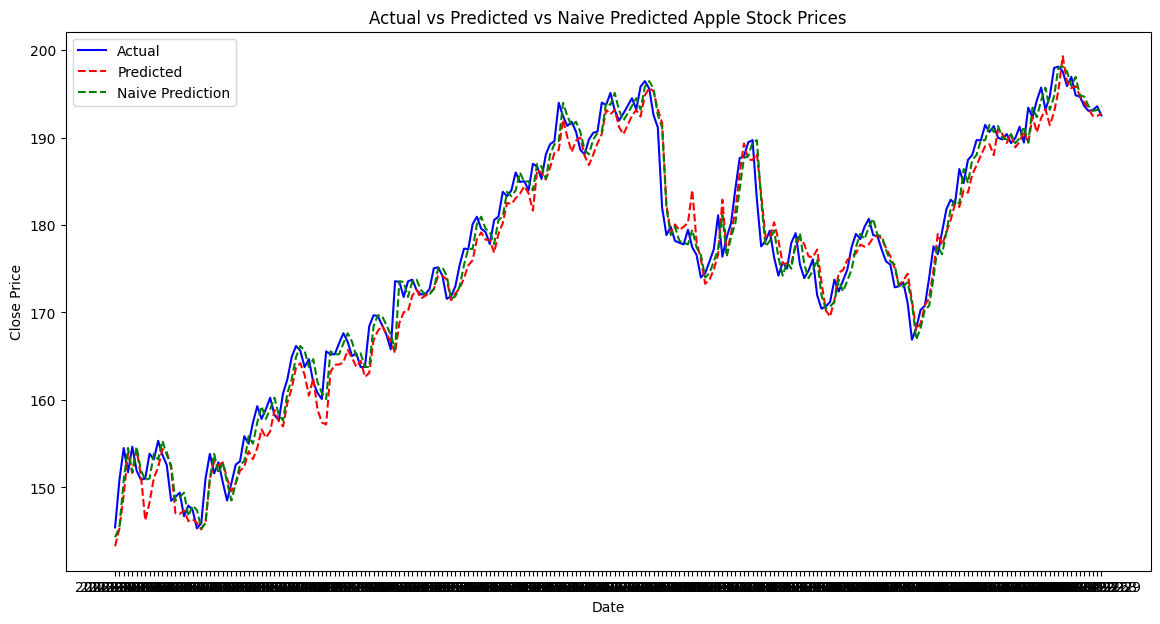

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


mse_model = mean_squared_error(results_df['y_actual'], results_df['y_predicted'])
print(f'MSE for the predictive model: {mse_model}')

# محاسبه MSE برای پیش‌بینی ناهموار (فرض می‌کنیم قیمت فردا برابر با قیمت امروز است)
results_df['y_naive'] = results_df['y_actual'].shift(1)  # قیمت ناهموار
results_df.dropna(inplace=True)


mse_naive = mean_squared_error(results_df['y_actual'], results_df['y_naive'])
print(f'MSE for the naive prediction: {mse_naive}')

# رسم نمودار مقایسه‌ای
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['y_actual'], label='Actual', color='blue')
plt.plot(results_df['ds'], results_df['y_predicted'], label='Predicted', color='red', linestyle='--')
plt.plot(results_df['ds'], results_df['y_naive'], label='Naive Prediction', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted vs Naive Predicted Apple Stock Prices')
plt.legend()
plt.show()


In [30]:
import pandas as pd



# Initialize variables for accuracy calculation
correct_predictions = 0
total_predictions = 0

# Iterate through each row in the DataFrame
for i in range(1, len(results_df)):
    # Get actual and predicted prices for the current and previous days
    actual_today = results_df.iloc[i]['y_actual']
    predicted_today = results_df.iloc[i]['y_predicted']
    actual_yesterday_index = i - 1
    actual_yesterday_date = results_df.iloc[actual_yesterday_index]['ds']

    # Check if the date of the previous row is the previous day of the current row
    if pd.to_datetime(actual_yesterday_date) != pd.to_datetime(results_df.iloc[i]['ds']) - pd.DateOffset(days=1):
        continue  # Skip this row if the previous date is not the previous day

    actual_yesterday = results_df.iloc[actual_yesterday_index]['y_actual']

    # Calculate actual and predicted movements
    actual_movement = actual_today - actual_yesterday
    predicted_movement = predicted_today - actual_yesterday  # We use yesterday's actual price as reference

    # Check if the directions of actual and predicted movements match
    if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
        correct_predictions += 1

    total_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / total_predictions
print("Accuracy based on price movements:", accuracy)


Accuracy based on price movements: 0.4388888888888889


In [25]:
results_df

,ds,y_actual,y_predicted,y_naive
1,2023-02-01,145.429993,143.27422,144.289993
2,2023-02-02,150.820007,145.29051,145.429993
3,2023-02-03,154.500000,149.09167,150.820007
4,2023-02-06,151.729996,153.94092,154.500000
5,2023-02-07,154.649994,151.65108,151.729996
...,...,...,...,...
226,2023-12-22,193.600006,194.00093,194.679993
227,2023-12-26,193.050003,193.26372,193.600006
228,2023-12-27,193.149994,192.47777,193.050003
229,2023-12-28,193.580002,192.47534,193.149994


Total Profit: 25.80 USD
             ds    y_actual  y_predicted signal  buy_sell_all_capital
1    2023-02-01  145.429993    143.27422    Buy            100.000000
2    2023-02-02  150.820007    145.29051    Buy            103.706261
3    2023-02-03  154.500000    149.09167    Buy            106.236683
4    2023-02-06  151.729996    153.94092   Sell            104.331983
5    2023-02-07  154.649994    151.65108    Buy            104.331983
..          ...         ...          ...    ...                   ...
226  2023-12-22  193.600006    194.00093   Sell            126.490572
227  2023-12-26  193.050003    193.26372   Sell            126.490572
228  2023-12-27  193.149994    192.47777   Sell            126.490572
229  2023-12-28  193.580002    192.47534    Buy            126.490572
230  2023-12-29  192.529999    192.73610   Sell            125.804470

[230 rows x 5 columns]


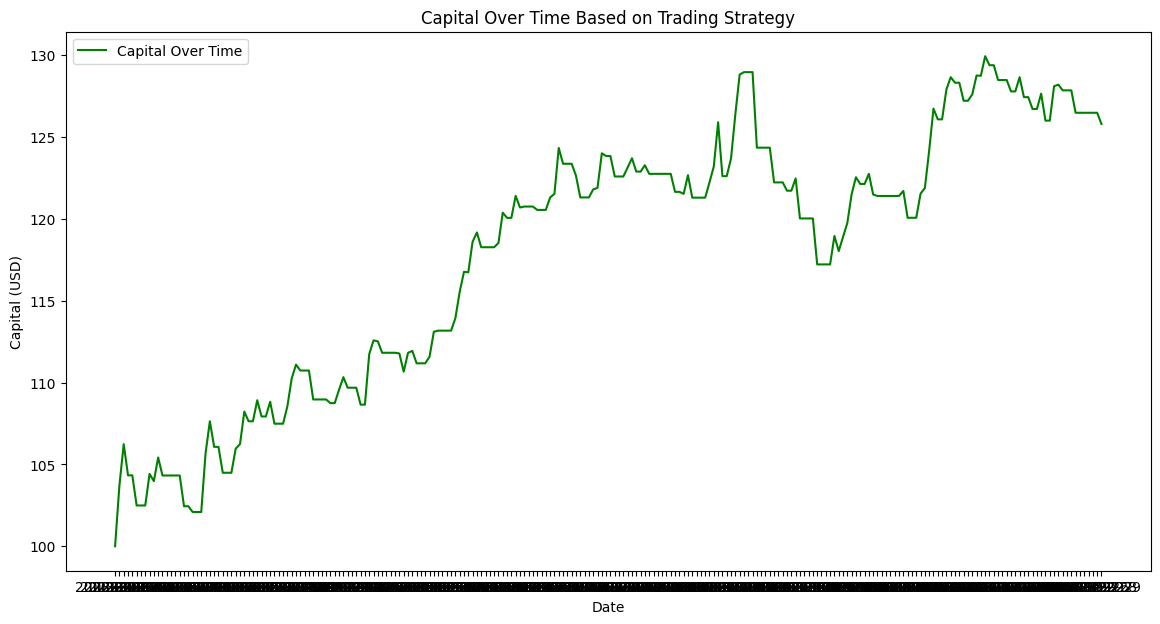

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# ایجاد سیگنال‌های خرید و فروش
results_df['signal'] = np.where(results_df['y_predicted'].shift(-1) > results_df['y_predicted'], 'Buy', 'Sell')

# تنظیمات اولیه سرمایه
initial_investment = 100  # سرمایه اولیه
capital = initial_investment  # سرمایه اولیه
shares = 0  # تعداد سهام خریداری شده
profit = 0  # سود کل

# لیستی برای ذخیره سود و سرمایه روزانه
capital_history = []
# محاسبه سود و زیان بر اساس سیگنال‌ها
for i in range(len(results_df) - 1):
    i=i+1
    if results_df.loc[i, 'signal'] == 'Buy' and capital > 0:
        # خرید سهام با تمام سرمایه
        shares = capital / results_df.loc[i, 'y_actual']

        capital = 0  # تمام سرمایه به سهام تبدیل می‌شود
    elif results_df.loc[i, 'signal'] == 'Sell' and shares > 0:

        # فروش تمام سهام و تبدیل به پول نقد
        capital = shares * results_df.loc[i, 'y_actual']
        shares = 0  # تمام سهام فروخته می‌شود
    # ذخیره سرمایه روزانه
    capital_history.append(capital + shares * results_df.loc[i, 'y_actual'])

# # محاسبه سود نهایی
final_capital = capital + shares * results_df.iloc[-1]['y_actual']
total_profit = final_capital - initial_investment

print(f'Total Profit: {total_profit:.2f} USD')

# # نمایش سیگنال‌ها و سود هر روز
results_df['buy_sell_all_capital'] = capital_history + [final_capital]
print(results_df[['ds', 'y_actual', 'y_predicted', 'signal', 'buy_sell_all_capital']])

# # رسم نمودار سود تجمعی
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['buy_sell_all_capital'], label='Capital Over Time', color='green')
plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Capital Over Time Based on Trading Strategy')
plt.legend()
plt.show()


Total Profit: 19.88 USD
             ds    y_actual  y_predicted signal  naive_capital
1    2023-02-01  145.429993    143.27422    Buy     100.000000
2    2023-02-02  150.820007    145.29051    Buy     103.706261
3    2023-02-03  154.500000    149.09167    Buy     106.236683
4    2023-02-06  151.729996    153.94092   Sell     104.331983
5    2023-02-07  154.649994    151.65108    Buy     104.331983
..          ...         ...          ...    ...            ...
226  2023-12-22  193.600006    194.00093   Sell     120.265331
227  2023-12-26  193.050003    193.26372   Sell     120.265331
228  2023-12-27  193.149994    192.47777    Buy     120.265331
229  2023-12-28  193.580002    192.47534    Buy     120.533076
230  2023-12-29  192.529999    192.73610   Sell     119.879289

[230 rows x 5 columns]


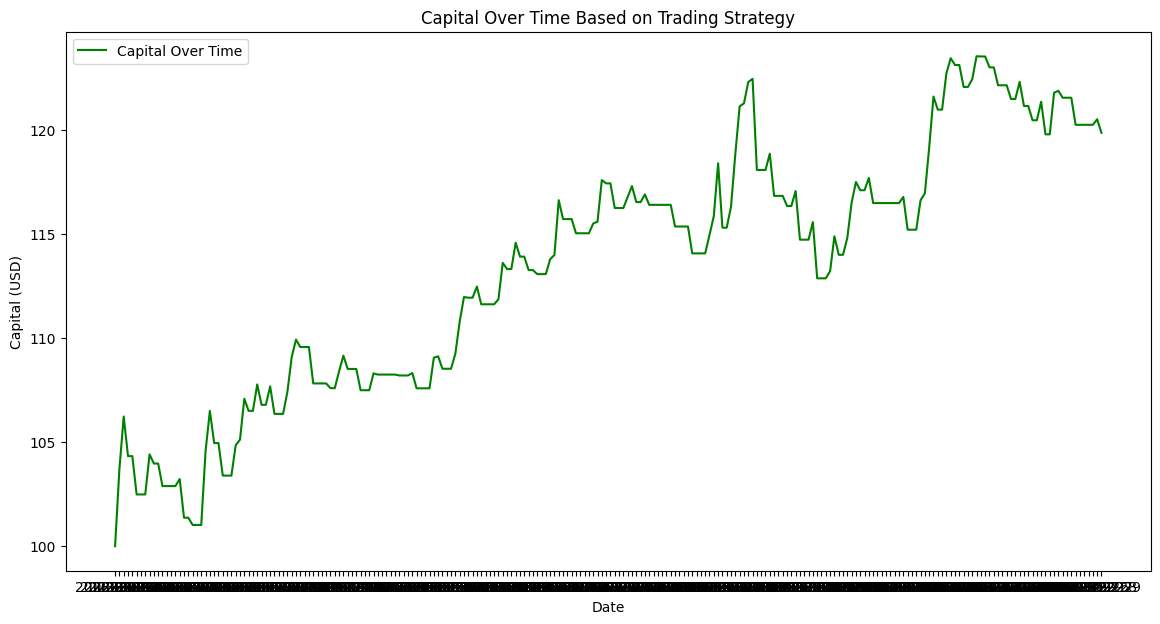

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# ایجاد سیگنال‌های خرید و فروش
results_df['signal'] = np.where(results_df['y_naive'].shift(-1) > results_df['y_naive'], 'Buy', 'Sell')

# تنظیمات اولیه سرمایه
initial_investment = 100  # سرمایه اولیه
capital = initial_investment  # سرمایه اولیه
shares = 0  # تعداد سهام خریداری شده
profit = 0  # سود کل

# لیستی برای ذخیره سود و سرمایه روزانه
capital_history = []


# محاسبه سود و زیان بر اساس سیگنال‌ها
for i in range(len(results_df) - 1):
    i=i+1
    if results_df.loc[i, 'signal'] == 'Buy' and capital > 0:
        # خرید سهام با تمام سرمایه
        shares = capital / results_df.loc[i, 'y_actual']

        capital = 0  # تمام سرمایه به سهام تبدیل می‌شود
    elif results_df.loc[i, 'signal'] == 'Sell' and shares > 0:

        # فروش تمام سهام و تبدیل به پول نقد
        capital = shares * results_df.loc[i, 'y_actual']
        shares = 0  # تمام سهام فروخته می‌شود
    # ذخیره سرمایه روزانه
    capital_history.append(capital + shares * results_df.loc[i, 'y_actual'])

# # محاسبه سود نهایی
final_capital = capital + shares * results_df.iloc[-1]['y_actual']
total_profit = final_capital - initial_investment

print(f'Total Profit: {total_profit:.2f} USD')

# # نمایش سیگنال‌ها و سود هر روز
results_df['naive_capital'] = capital_history + [final_capital]
print(results_df[['ds', 'y_actual', 'y_predicted', 'signal', 'naive_capital']])

# # رسم نمودار سود تجمعی
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['naive_capital'], label='Capital Over Time', color='green')
plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Capital Over Time Based on Trading Strategy')
plt.legend()
plt.show()


Total Profit: 18.81 USD
             ds    y_actual  y_predicted signal  buy_fraction_sell_all_capital
1    2023-02-01  145.429993    143.27422    Buy                     100.000000
2    2023-02-02  150.820007    145.29051    Buy                     101.853130
3    2023-02-03  154.500000    149.09167    Buy                     103.728339
4    2023-02-06  151.729996    153.94092   Sell                     102.092721
5    2023-02-07  154.649994    151.65108    Buy                     102.092721
..          ...         ...          ...    ...                            ...
226  2023-12-22  193.600006    194.00093   Sell                     119.134175
227  2023-12-26  193.050003    193.26372   Sell                     119.134175
228  2023-12-27  193.149994    192.47777   Sell                     119.134175
229  2023-12-28  193.580002    192.47534    Buy                     119.134175
230  2023-12-29  192.529999    192.73610   Sell                     118.811075

[230 rows x 5 columns]


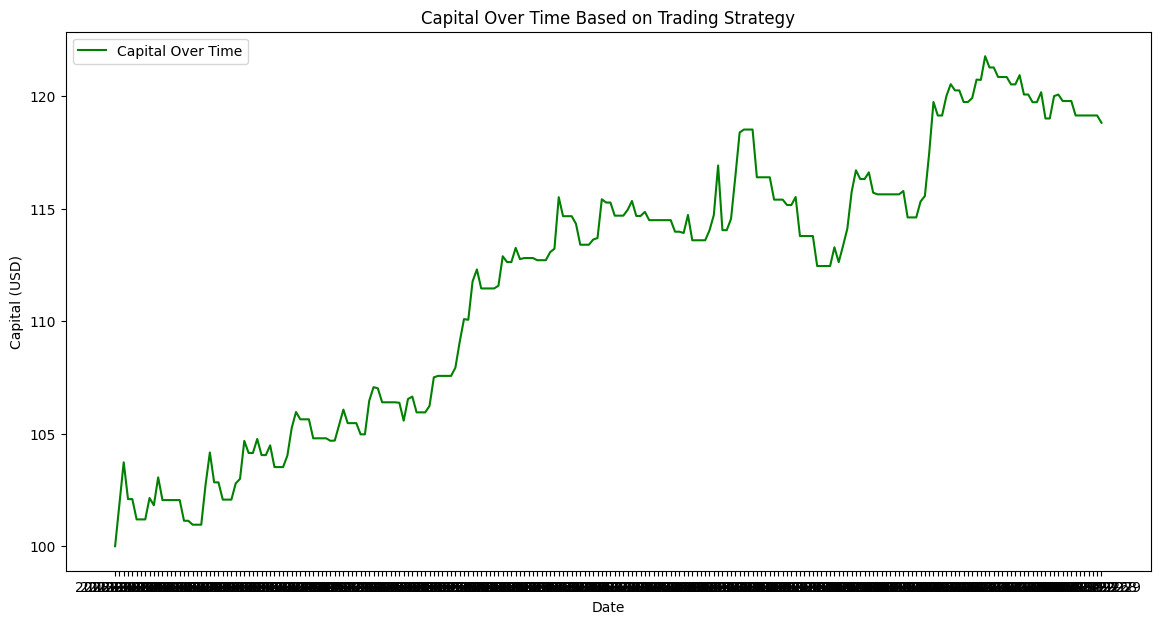

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# ایجاد سیگنال‌های خرید و فروش
results_df['signal'] = np.where(results_df['y_predicted'].shift(-1) > results_df['y_predicted'], 'Buy', 'Sell')

# تنظیمات اولیه سرمایه
initial_investment = 100  # سرمایه اولیه
capital = initial_investment  # سرمایه اولیه
shares = 0  # تعداد سهام خریداری شده
profit = 0  # سود کل
trading_fraction = 0.5

# لیستی برای ذخیره سود و سرمایه روزانه
capital_history = []
# محاسبه سود و زیان بر اساس سیگنال‌ها
for i in range(len(results_df) - 1):
    i=i+1
    if results_df.loc[i, 'signal'] == 'Buy' and capital > 0:
        investment_amount = capital * trading_fraction
        shares_bought = investment_amount / results_df.loc[i, 'y_actual']
        shares += shares_bought
        capital -= investment_amount
    elif results_df.loc[i, 'signal'] == 'Sell' and shares > 0:

        shares_sold = shares
        capital += shares_sold * results_df.loc[i, 'y_actual']
        shares -= shares_sold
    # ذخیره سرمایه روزانه
    capital_history.append(capital + shares * results_df.loc[i, 'y_actual'])

# # محاسبه سود نهایی
final_capital = capital + shares * results_df.iloc[-1]['y_actual']
total_profit = final_capital - initial_investment

print(f'Total Profit: {total_profit:.2f} USD')

# # نمایش سیگنال‌ها و سود هر روز
results_df['buy_fraction_sell_all_capital'] = capital_history + [final_capital]
print(results_df[['ds', 'y_actual', 'y_predicted', 'signal', 'buy_fraction_sell_all_capital']])

# # رسم نمودار سود تجمعی
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['buy_fraction_sell_all_capital'], label='Capital Over Time', color='green')
plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Capital Over Time Based on Trading Strategy')
plt.legend()
plt.show()


Total Profit: 21.21 USD
             ds    y_actual  y_predicted signal  buy_sell_fraction_capital
1    2023-02-01  145.429993    143.27422    Buy                 100.000000
2    2023-02-02  150.820007    145.29051    Buy                 101.853130
3    2023-02-03  154.500000    149.09167    Buy                 103.728339
4    2023-02-06  151.729996    153.94092   Sell                 102.092721
5    2023-02-07  154.649994    151.65108    Buy                 102.954814
..          ...         ...          ...    ...                        ...
226  2023-12-22  193.600006    194.00093   Sell                 121.563644
227  2023-12-26  193.050003    193.26372   Sell                 121.537301
228  2023-12-27  193.149994    192.47777   Sell                 121.539696
229  2023-12-28  193.580002    192.47534    Buy                 121.544844
230  2023-12-29  192.529999    192.73610   Sell                 121.208921

[230 rows x 5 columns]


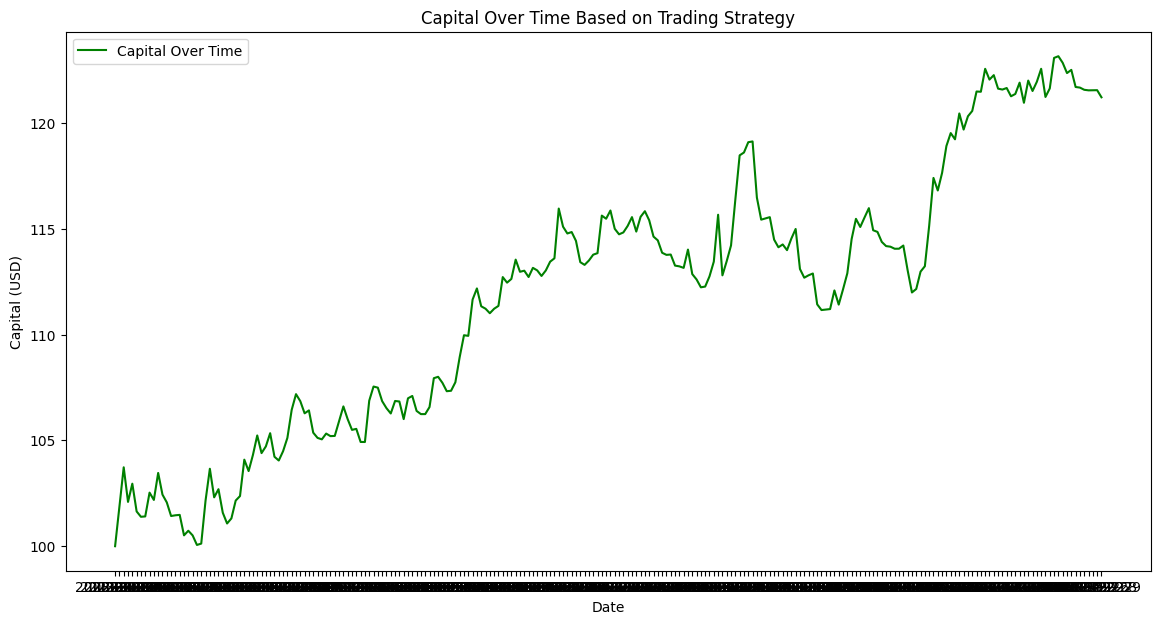

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# ایجاد سیگنال‌های خرید و فروش
results_df['signal'] = np.where(results_df['y_predicted'].shift(-1) > results_df['y_predicted'], 'Buy', 'Sell')

# تنظیمات اولیه سرمایه
initial_investment = 100  # سرمایه اولیه
capital = initial_investment  # سرمایه اولیه
shares = 0  # تعداد سهام خریداری شده
profit = 0  # سود کل
trading_fraction = 0.5

# لیستی برای ذخیره سود و سرمایه روزانه
capital_history = []
# محاسبه سود و زیان بر اساس سیگنال‌ها
for i in range(len(results_df) - 1):
    i=i+1
    if results_df.loc[i, 'signal'] == 'Buy' and capital > 0:
        investment_amount = capital * trading_fraction
        shares_bought = investment_amount / results_df.loc[i, 'y_actual']
        shares += shares_bought
        capital -= investment_amount
    elif results_df.loc[i, 'signal'] == 'Sell' and shares > 0:

        shares_sold = shares * trading_fraction
        capital += shares_sold * results_df.loc[i, 'y_actual']
        shares -= shares_sold
    # ذخیره سرمایه روزانه
    capital_history.append(capital + shares * results_df.loc[i, 'y_actual'])

# # محاسبه سود نهایی
final_capital = capital + shares * results_df.iloc[-1]['y_actual']
total_profit = final_capital - initial_investment

print(f'Total Profit: {total_profit:.2f} USD')

# # نمایش سیگنال‌ها و سود هر روز
results_df['buy_sell_fraction_capital'] = capital_history + [final_capital]
print(results_df[['ds', 'y_actual', 'y_predicted', 'signal', 'buy_sell_fraction_capital']])

# # رسم نمودار سود تجمعی
plt.figure(figsize=(14, 7))
plt.plot(results_df['ds'], results_df['buy_sell_fraction_capital'], label='Capital Over Time', color='green')
plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Capital Over Time Based on Trading Strategy')
plt.legend()
plt.show()


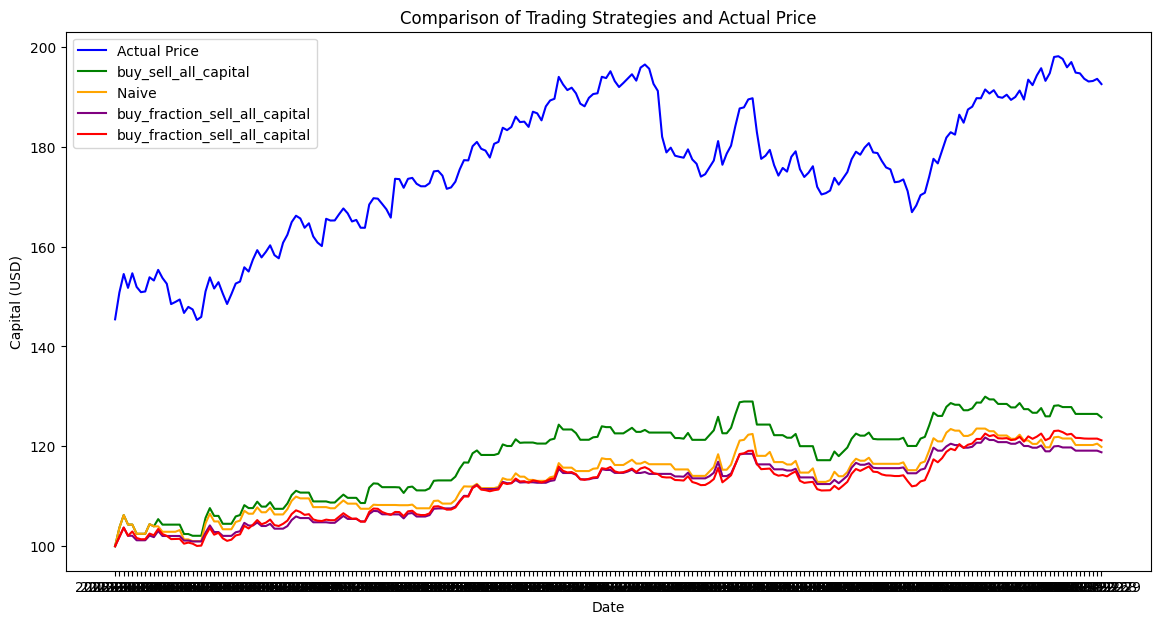

In [39]:
plt.figure(figsize=(14, 7))


plt.plot(results_df['ds'], results_df['y_actual'], label='Actual Price', color='blue')


plt.plot(results_df['ds'], results_df['buy_sell_all_capital'], label='buy_sell_all_capital', color='green')


plt.plot(results_df['ds'], results_df['naive_capital'], label='Naive ', color='orange')


plt.plot(results_df['ds'],results_df['buy_fraction_sell_all_capital'] , label='buy_fraction_sell_all_capital', color='purple')

plt.plot(results_df['ds'],results_df['buy_sell_fraction_capital'] , label='buy_fraction_sell_all_capital', color='red')

plt.xlabel('Date')
plt.ylabel('Capital (USD)')
plt.title('Comparison of Trading Strategies and Actual Price')
plt.legend()
plt.show()

In [57]:
results_df_predict=pd.read_csv('/content/one_month_input_one_dY.csv',)
results_df_predict

,ds,y_actual,y_predicted
0,2023-01-31,144.289993,140.42755
1,2023-02-01,145.429993,143.24666
2,2023-02-02,150.820007,145.26890
3,2023-02-03,154.500000,149.06754
4,2023-02-06,151.729996,153.91434
...,...,...,...
226,2023-12-22,193.600006,193.98984
227,2023-12-26,193.050003,193.25229
228,2023-12-27,193.149994,192.46585
229,2023-12-28,193.580002,192.46298


In [58]:
results_df

,ds,y_actual,y_predicted,y_naive,signal,naive_capital,buy_fraction_sell_all_capital,buy_sell_fraction_capital,buy_sell_all_capital,difference
1,2023-02-01,145.429993,143.27422,144.289993,Buy,100.000000,100.000000,100.000000,100.000000,0.02756
2,2023-02-02,150.820007,145.29051,145.429993,Buy,103.706261,101.853130,101.853130,103.706261,0.02161
3,2023-02-03,154.500000,149.09167,150.820007,Buy,106.236683,103.728339,103.728339,106.236683,0.02413
4,2023-02-06,151.729996,153.94092,154.500000,Sell,104.331983,102.092721,102.092721,104.331983,0.02658
5,2023-02-07,154.649994,151.65108,151.729996,Buy,104.331983,102.092721,102.954814,104.331983,0.02375
...,...,...,...,...,...,...,...,...,...,...
226,2023-12-22,193.600006,194.00093,194.679993,Sell,120.265331,119.134175,121.563644,126.490572,0.01109
227,2023-12-26,193.050003,193.26372,193.600006,Sell,120.265331,119.134175,121.537301,126.490572,0.01143
228,2023-12-27,193.149994,192.47777,193.050003,Sell,120.265331,119.134175,121.539696,126.490572,0.01192
229,2023-12-28,193.580002,192.47534,193.149994,Buy,120.533076,119.134175,121.544844,126.490572,0.01236


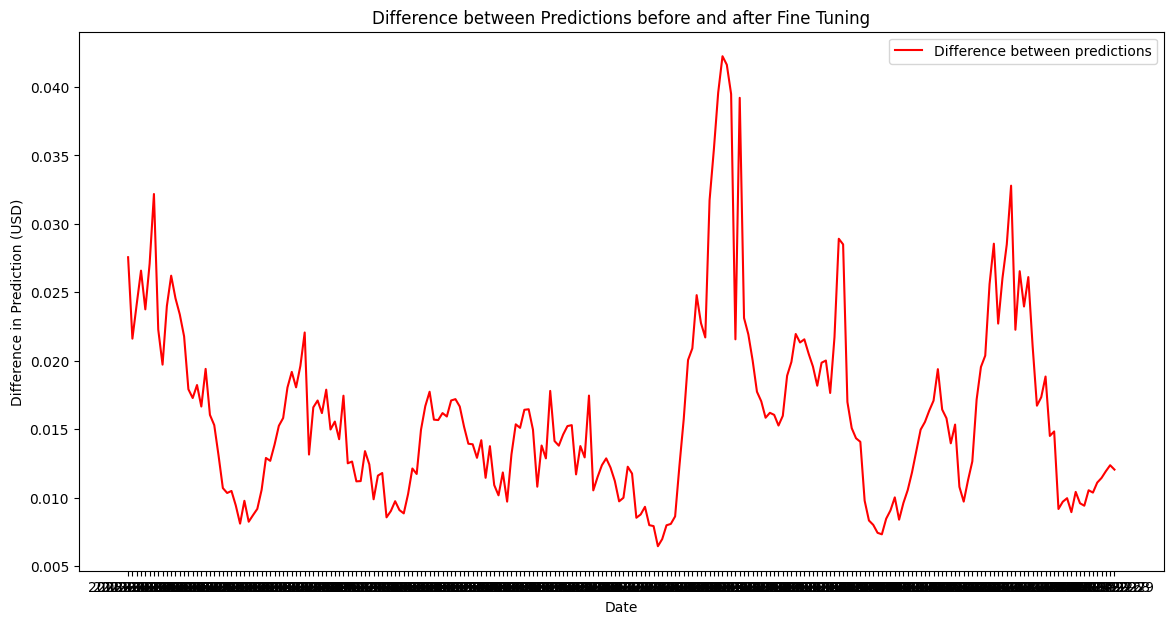

In [60]:
plt.figure(figsize=(14, 7))

# محاسبه تفاوت بین دو پیش‌بینی
results_df['difference'] = results_df['y_predicted'] - results_df_predict['y_predicted']

plt.plot(results_df['ds'], results_df['difference'], label='Difference between predictions', color='red')

plt.xlabel('Date')
plt.ylabel('Difference in Prediction (USD)')
plt.title('Difference between Predictions before and after Fine Tuning')
plt.legend()
plt.show()
